Using TensorFlow backend.


Found 560 validated image filenames.
Found 220 validated image filenames.
Found 220 validated image filenames.
Epoch 1/60
28/28 [==============================] - 1921s 69s/step - loss: 252.2168 - mean_absolute_error: 9.7305 - val_loss: 16.9243 - val_mean_absolute_error: 3.6652

Epoch 00001: val_mean_absolute_error improved from inf to 3.66515, saving model to meat_best.h5


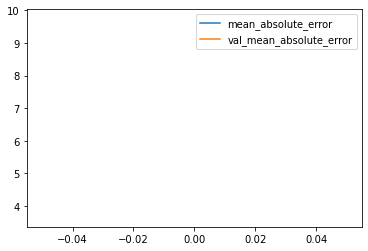

Epoch 2/60


KeyboardInterrupt: 

In [1]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd


BATCH_SIZE = 20
IMAGE_SIZE = (256,256)


dataframe = pd.read_csv('contest_foodweight/fried_noodles_dataset.csv', delimiter=',', header=0)


#https://keras.io/api/preprocessing/image/
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
datagen = ImageDataGenerator(
            rescale=1./255,
            brightness_range=[0.9,1.1],
            shear_range=1,
            zoom_range=0.05,
            rotation_range=10,
            width_shift_range=0.03,
            height_shift_range=0.03,
            vertical_flip=True,
            horizontal_flip=True)

datagen_noaug = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe.loc[0:559],
    directory='contest_foodweight/images',
    x_col='filename',
    y_col='meat',
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='other')

validation_generator = datagen_noaug.flow_from_dataframe(
    dataframe=dataframe.loc[560:779],
    directory='contest_foodweight/images',
    x_col='filename',
    y_col='meat',
    shuffle=False,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='other')

test_generator = datagen_noaug.flow_from_dataframe(
    dataframe=dataframe.loc[780:999],
    directory='contest_foodweight/images',
    x_col='filename',
    y_col='meat',
    shuffle=False,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='other')

inputIm = Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3,))
conv1 = Conv2D(64,3,activation='relu')(inputIm)
conv1 = Conv2D(64,3,activation='relu')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPool2D()(conv1)
conv2 = Conv2D(128,3,activation='relu')(pool1)
conv2 = Conv2D(128,3,activation='relu')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPool2D()(conv2)
conv3 = Conv2D(256,3,activation='relu')(pool2)
conv3 = Conv2D(256,3,activation='relu')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPool2D()(conv3)
conv4 = Conv2D(512,3,activation='relu')(pool3)
conv4 = Conv2D(512,3,activation='relu')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPool2D()(conv4)
conv5 = Conv2D(1024,3,activation='relu')(pool4)
conv5 = Conv2D(1024,3,activation='relu')(conv5)
conv5 = BatchNormalization()(conv5)
pool5 = MaxPool2D()(conv5)
flat = Flatten()(pool5)
dense1 = Dense(512,activation='sigmoid')(flat)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
predictedW = Dense(1,activation='sigmoid')(dense1)

model = Model(inputs=inputIm, outputs=predictedW)

model.compile(optimizer=Adam(lr = 1e-4), loss='mse', metrics=['mean_absolute_error'])


class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get('mean_absolute_error'))
        self.val_losses.append(logs.get('val_mean_absolute_error'))

        plt.clf()
        plt.plot(self.x, self.losses, label='mean_absolute_error')
        plt.plot(self.x, self.val_losses, label='val_mean_absolute_error')
        plt.legend()
        plt.pause(0.01)


checkpoint = ModelCheckpoint('meat_best.h5', verbose=1, monitor='val_mean_absolute_error',save_best_only=True, mode='min')
plot_losses = PlotLosses()

#Train Model
model.fit_generator(
    train_generator,
    steps_per_epoch= len(train_generator),
    epochs=60,
    validation_data=validation_generator,
    validation_steps= len(validation_generator),
    callbacks=[checkpoint, plot_losses])


#Test Model
model = load_model('meat_best.h5')
score = model.evaluate_generator(
    test_generator,
    steps=len(test_generator))
print('score (mse, mae):\n',score)

test_generator.reset()
predict = model.predict_generator(
    test_generator,
    steps=len(test_generator),
    workers = 1,
    use_multiprocessing=False)
print('prediction:\n',predict)


